# 1. App Review NLP work

This question uses the Apple App review dataset that you generated in the "Pulling online data" workshop. Your dataset should have at least 3-5 different applications, with data from a few countries.

**1.1** Using the bag-of-words or TF-IDF vector model (from SKLearn), cluster the reviews into 5 clusters. Measure the accuracy of the cluster overlap against the real review scores.

**1.2** Now use a sentence embedding using on of the `gensim` pre-trained word embedding models to achieve the same in clustering. Get the best classification accuracy score you can on the 5-star review scale targer using all unsupervised methods you want.

**1.3** Using any method you want (pre-trained models, dimensionality reduction, feature engineering, etc.) make the best **regression** model you can to predict the 5 star rating. Rate the accuracy in regression terms (mean squared error) and in classification terms (accuracy score, etc.)

**1.4** Do the same as in 1.3, but use a classification model. Are classification models better or worse to predict a 5-point rating scale? Explain in a few paragraphs and justify with metrics.


In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import sklearn
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score
import statsmodels.api as sm
import sys

### Gensim is outside the anaconda distribution ###
### uncomment to install Gensim ###
# !{sys.executable} -m pip install gensim
import gensim
import gensim.downloader as model_api

In [2]:
# Load pretrained word embeddings
# This will download 60mb of data the first time it's loaded
word_vectors = model_api.load("glove-wiki-gigaword-50")

In [3]:
import requests
import json

In [4]:
# 1.1 bag-of-words or TF-IDF vector model (from SKLearn)

final = []
co = ['us', 'gb', 'ca', 'au']
app_id = [553834731,547702041,284882215,333903271]
add_name = ['Candy Crush','Tinder','Facebook','Twitter']
apps = dict(zip(app_id, add_name))

pp = 1
for c in co:
    pp = 1
    for app in apps:
        try:
            r = requests.get(f"https://itunes.apple.com/{c}/rss/customerreviews/id={app}/page={pp}/sortby=mostrecent/json")
            cc = json.loads(r.content)
            if r.status_code == 200:
                for i in cc['feed']['entry']:
                    final.append((apps[app],app,c,i['content']['label'],i['im:rating']['label']))
            pp += 1
        except:
            print('error')

df = pd.DataFrame(final)
df.columns=['app','app_id','country','eng_review','rating']
df

,app,app_id,country,eng_review,rating
0,Candy Crush,553834731,us,This game has no ads! And so fun and easy. Thi...,5
1,Candy Crush,553834731,us,"I enjoy this game so much I have 2 accounts, t...",2
2,Candy Crush,553834731,us,Keeps locking up.,3
3,Candy Crush,553834731,us,The app won’t load ever since the new update,1
4,Candy Crush,553834731,us,I think that this app is great. I’ve been play...,5
...,...,...,...,...,...
795,Twitter,333903271,au,Literally silences everyone and falsely fact-c...,1
796,Twitter,333903271,au,The most leftist app out there try to tweet on...,1
797,Twitter,333903271,au,DONALD TRUMP\nDONALD TRUMP\nDONALD TRUMP\nAwfu...,1
798,Twitter,333903271,au,Ban Trump the leader of the free world. You ar...,1


In [5]:
df['rating'] = df['rating'].astype(int)
df.dtypes

app           object
app_id         int64
country       object
eng_review    object
rating         int32
dtype: object

In [6]:
import sklearn.feature_extraction.text as text

tf = text.TfidfVectorizer()
X = tf.fit_transform(df['eng_review'])

Xd = X.toarray()
Xd = PCA(5).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)

pred = Xd @ sc.linalg.inv(Xd.T @ Xd) @ Xd.T @ df['rating'].values
print("OLS R^2: ", r2_score(df['rating'], pred))

OLS R^2:  0.14916482227527572


In [7]:
# 1.2 sentence embedding using on of the gensim pre-trained word embedding models

In [8]:
import re

replaceDict = dict({
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ",
})

rep = dict((re.escape(k), v) for k, v in replaceDict.items())
pattern = re.compile("|".join(rep.keys()))
def replacer(text):
    return rep[re.escape(text.group(0))]

words = df['eng_review'].str.replace(pattern, replacer).str.lower().str.split()
words = pd.DataFrame(words.tolist())
words

,0,1,2,3,4,5,6,7,8,9,...,304,305,306,307,308,309,310,311,312,313
0,this,game,has,no,ads,and,so,fun,and,easy,...,None,None,None,None,None,None,None,None,None,None
1,i,enjoy,this,game,so,much,i,have,2,accounts,...,None,None,None,None,None,None,None,None,None,None
2,keeps,locking,up,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,the,app,won’t,load,ever,since,the,new,update,None,...,None,None,None,None,None,None,None,None,None,None
4,i,think,that,this,app,is,great,i’ve,been,playing,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,literally,silences,everyone,and,falsely,fact,checks,None,None,None,...,None,None,None,None,None,None,None,None,None,None
796,the,most,leftist,app,out,there,try,to,tweet,one,...,None,None,None,None,None,None,None,None,None,None
797,donald,trump,donald,trump,donald,trump,awful,twitter,leader,None,...,None,None,None,None,None,None,None,None,None,None
798,ban,trump,the,leader,of,the,free,world,you,are,...,None,None,None,None,None,None,None,None,None,None


In [9]:
def soft_get(w):
    try:
        return word_vectors[w]
    except KeyError:
        return np.zeros(word_vectors.vector_size)

def map_vectors(row):
    try:
        return np.sum(
            row.loc[words.iloc[0].notna()].apply(soft_get)
        )
    except:
        return np.zeros(word_vectors.vector_size)

emb = pd.DataFrame(words.apply(map_vectors, axis=1).tolist())
emb

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,2.572840,1.144907,-1.908477,1.792536,5.235116,3.014586,-10.919446,-3.825145,-4.654397,4.021591,...,-1.553306,2.738598,-3.260685,4.954154,-0.979714,2.732576,-1.311605,-0.706615,0.356714,3.521130
1,3.327957,1.216045,-0.024307,-0.008596,6.682922,0.683320,-9.078716,-0.829894,-6.747550,1.227651,...,-1.714220,-0.740565,-0.780290,4.939043,-4.238529,3.648146,-1.724025,-0.162371,-0.823199,1.986221
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,6.075463,3.041703,-1.337815,-0.145319,5.389037,3.279720,-8.473165,-2.765878,-2.425110,1.482476,...,-3.653441,3.054181,-2.115671,3.601990,-0.203514,2.347634,-3.398054,1.814823,-0.760225,3.029245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
796,5.586527,-1.355929,3.779160,-2.814723,4.520585,0.680875,-7.041411,-2.283263,-5.093330,2.573713,...,-1.295138,1.414200,-2.835821,2.912663,2.566159,0.928262,-0.154398,0.246890,0.232097,-2.896499
797,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
798,3.509608,2.821099,-0.314663,1.631984,5.233296,0.497460,-4.316291,-1.905288,-1.688389,1.906990,...,-4.176888,1.796388,0.109847,4.725317,1.255293,2.428861,-5.929554,-1.273795,0.115409,-2.212722


In [10]:
sgdr = SGDRegressor()
sgdr.fit(emb, df['rating'])
sgdr.score(emb, df['rating'])

-7.292396264248137e+23

In [11]:
# 1.3 make the best regression model you can to predict the 5 star rating

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
emb = scaler.fit_transform(emb)

X = tf.fit_transform(df['eng_review'])

Xd = X.toarray()
Xd = PCA(50).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)

pred = Xd @ sc.linalg.inv(Xd.T @ Xd) @ Xd.T @ df['rating'].values
print("OLS R^2: ", r2_score(df['rating'], pred))

OLS R^2:  0.3490711995841026


In [13]:
# 1.4 use a classification model

In [14]:
from sklearn.model_selection import train_test_split
y = df['rating']
X_train, X_test, y_train, y_test = train_test_split(Xd, y, test_size=0.15, random_state=42)

In [15]:
from sklearn import tree

dtree = tree.DecisionTreeClassifier(max_depth=10, random_state=101, max_features=None, min_samples_leaf=15)
dtree.fit(X_train,y_train)
y_pred = dtree.predict(X_test)

In [16]:
from sklearn import metrics
# print(metrics.confusion_matrix(y_test, y_pred))
# print(metrics.classification_report(y_test, y_pred))
print("OLS R^2: ", metrics.r2_score(y_test, y_pred))

OLS R^2:  0.019634211941904067


## 2. Face data

Here let's apply manifold learning on some face data.

Use the following code:

```
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
```

To get the `faces` dataset.

Use dimensionality reduction so that the darkness of the image is sorted in the first dimension as seen in this picture:

![](isofaces.png)

Then produce a picture similar to this one with your result

In [17]:
# pip install umap-learn

In [18]:
# conda install numba

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [20]:
from sklearn.datasets import fetch_lfw_people

In [21]:
faces = fetch_lfw_people(min_faces_per_person=30)

In [22]:
data = faces.data
images = faces.images

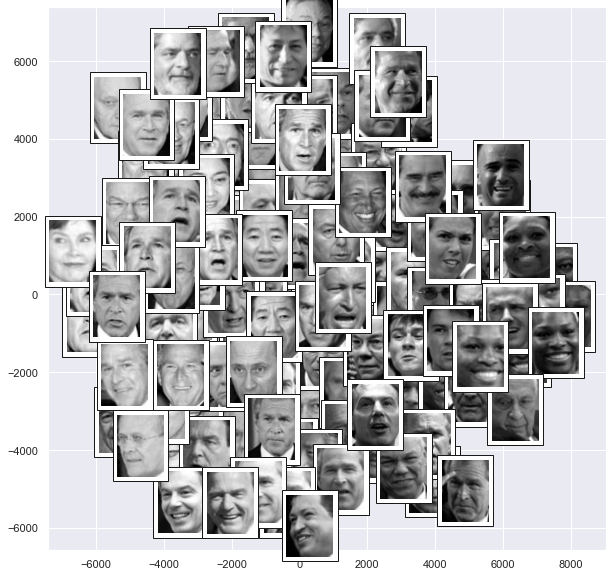

In [23]:
from sklearn.manifold import Isomap
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),proj[i])
            ax.add_artist(imagebox)

fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_components=2)
plot_components(data, model, images=images, ax=ax, thumb_frac=0.05)